   ## TP 1 - Algorithmes de descente en optimisation différentiable

Dans ce TP, nous allons nous intéresser aux algorithmes les plus classiques de minimisation sans contrainte: algorithmes de descente de gradient, algorithmes de type Newton.

In [1]:
import numpy as np
import numpy.linalg as npl
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

Le but de cette séance est l'écriture d'un code de minimisation locale et l'évaluation de des performances sur les fonctions tests suivantes:
$$f_1(x,y) = \frac{1}{2}x^2+\frac{7}{2}y^2.$$
$$f_2(x,y) = \frac{1}{2}x^2+x \cos y.$$
$$f_3(x,y) = 100(y-x^2)^2 + (1-x)^2.$$


Commencez par implémenter les trois fonctions test proposées. Chaque fonction $f_i$ prend en entrée un vecteur x et renvoie $[f(x), \nabla f(x), H_f(x)]$

In [2]:
x = np.array([[1,2],[2,2]])
x[:,0]**2 + x[:,1]

array([3, 6])

In [34]:
# Fonctions tests
def f1(x):
    fx = 0.5*x[0]**2 + 3.5*x[1]**2
    df = np.array([x[0], 7*x[1]])
    Hf = np.array([[1,0],[0,7]])
    return fx, df, Hf
  
def f2(x):
    f = 0.5*x[0]**2 + x[0]*np.cos(x[1])
    df = np.array([x[0] + np.cos(x[1]), -x[0]*np.sin(x[1])])
    Hf = np.array([[1, -np.sin(x[1])], [-np.sin(x[1]), -x[0]*np.cos(x[1])]])
    return f,df,Hf

def f3(x) :
    a, b = x[0], x[1]
    f = 100*(b-a**2)**2 + (1-a)**2
    df = np.array([400*a**3 - 400*a*b + 2*a - 2, 200*(b-a**2)])
    Hf = np.array([[1200*a**2 - 400*b + 2, -400*a], [-400*a, 200]])
    return f,df,Hf

Dans ce TP, nous allons implémenter des algorithmes de descente de gradient ainsi que l'algorithme de Newton:
$$x_{k+1} = x_k + s_kd_k,$$
où $d_k$ désigne la direction de recherche choisie et $s_k>0$ le pas. Dans une première partie, nous allons implémenter deux directions de recherche $d_k$: 
- la stratégie de Cauchy : $d_k=-\nabla f(x_k)$ conduisant aux algorithmes de gradient
- la stratégie de Newton : $d_k= -H_f(x_k)^{-1} \nabla f(x_k)$ conduisant aux algorithmes newtoniens

Dans la seconde partie nous allons implémenter plusieurs stratégies de recherche linéaire:
- Pas fixe : $\forall k, s_k=s$
- Recherche linéaire par rebroussement
- Recherche linéaire partielle/heuristique
- Recherche linéaire de Wolfe

Vous testerez au fur et à mesure vos algorithmes : gradient à pas fixe, Newton (pas fixe égal à $1$), puis dans un second temps avec rebroussement, etc. Le but de ce TP est de comprendre et illustrer le Chapitre 5 du polycopié de cours (pages 57 à 65).

### 1. Implémentation de plusieurs stratégies de directions de recherche

1. Implémenter une fonction qui dc_gradient qui renvoie la direction de plus forte de descente de $f$ en $x$ 

In [4]:
def dc_gradient(x,function) :
    return -function(x)[1]

2. Implémenter une fonction qui dc_newton qui renvoie la direction de Newton de $f$ en $x$

In [5]:
def dc_Newton(x,function) :
    [df, Hf] = function(x)[1:]
    d = npl.solve(Hf, -df)
    return d

In [33]:
dc_Newton([1,2],f2)

TypeError: bad operand type for unary -: 'list'

### 2. Implémentation de plusieurs stratégies de recherche linéaire

#### 1.1. Pas constant
La fonction de recherche linéaire ls_constant qui réalise un pas fixe vous est donnée ci-après. 

In [6]:
def ls_constant(x,function,step,descent) :
    return step

#### 1.2. Recherche linéaire par rebroussement
On s'intéresse maintenant à une stratégie de recherche linéaire par rebroussement: plus précisément, étant donnée une direction de descente $d_k$ et un pas $s>0$ initial donné, on divise le pas $s$ par $2$ tant que 
$$f(x_k+s d_k) \geqslant f(x_k)$$

1. Implémenter une fonction de recherche linéaire ls_backtracking qui calcule un pas par rebroussement. 

In [7]:
def ls_backtracking(x,function,step,descent):
    while function(x + step*descent) >= function(x):
        step = step/2
    return step

#### 1.3. Recherche linéaire heuristique
Implémenter une fonction de recherche linéaire ls_partial_linesearch qui calcule le pas $s_{k+1}$ parmi $\{0.1 s_k,0.5s_k,s_k,2s_k,10s_k\}$ qui minimise $f(x_k+sd_k)$.

In [8]:
T = np.array([0.1, 0.5, 1, 2, 10])
step = 2
x = [1,2]
descent = f1(x)[1]
[x + step*T[i]*descent for i in range(5)]
x_arr = np.array([x + step*T[i]*descent for i in range(5)])
f_arr = np.array([f1(x_arr[i,:])[0] for i in range(5)])
print(x_arr)
print(f_arr)

[[  1.2   4.8]
 [  2.   16. ]
 [  3.   30. ]
 [  5.   58. ]
 [ 21.  282. ]]
[8.136000e+01 8.980000e+02 3.154500e+03 1.178650e+04 2.785545e+05]


In [9]:
def ls_partial_linesearch(x,function,step,descent):
    T = np.array([0.1, 0.5, 1, 2, 10])
    x_arr = np.array([x + step*T[i]*descent for i in range(5)])
    f_arr = np.array([function(x_arr[i,:])[0] for i in range(5)])
    i = np.argmin(f_arr)
    step = step*T[i]
    return step

#### 1.4. Recherche linéaire de Wolfe
On rappelle ici les conditions de Wolfe
$$f(x_k +s~d_k) \leq f(x_k) + \varepsilon_1 s\left(\nabla f(x_k)^\top d_k\right), \hspace{1cm} \nabla f(x_k+s d_k)^\top d_k \geq \varepsilon_2\left(\nabla f(x_k)^\top d_k\right).$$
avec, en pratique: $\varepsilon_1 = 10^{-4}$ et $\varepsilon_2=0.9$. Implémenter une fonction ls_wolfe.

In [10]:
def ls_wolfe(x,function,step,descent, eps1 = 1e-4, eps2=0.99):
    s_minus = 0
    s_plus = np.inf
    fx, df = function(x)[0:2]
    while (function(x + step*descent)[0] >= fx + eps1*step*np.inner(df,descent)) or (np.inner(function(x + step*descent)[1], descent) < eps2*np.inner(df,descent)):
        if function(x + step*descent)[0] >= fx + eps1*step*np.inner(df,descent):
            s_plus = step
            step = (s_minus + s_plus)/2
        if np.inner(function(x + step*descent)[1], descent) < eps2*np.inner(df,descent):
            s_minus = step
            if s_plus < np.inf:
                step = (s_minus + s_plus)/2
            else:
                step = 2*step
    
    return step

#### 1.5. Recherche linéaire de Wolfe par interpolation cubique.

On pose: $\varphi_k(x) = f(x_k + x d_k)$. Rappelons que: $\varphi_k'(x) = \nabla f(x_k + x d_k)^\top d_k$.

* Soit $s>0$ fixé. Calculer (à la main !) le polynôme de degré $3$:
$p_s(x) = a + bx + c x^2+d x^3$
qui approxime $\varphi_k$ sur $[0,s]$ de sorte que:
$$p_s(0) = \varphi_k(0), \quad p_s(s)=\varphi_k(s),\quad p_s'(0)=\varphi_k'(0),\quad p_s'(s)=\varphi_k'(s).$$

* Montrer que le minimum de $p_s$ est atteint en un $x_s$ tel que: $b+2c x_s+3dx_s^2=0$.

* Implémenter une fonction ls_wolfe_cubique permettant de calculer un pas $s>0$ vérifiant les conditions de Wolfe selon l'algorithme suivant:

> Initialisation: $s=1$ (pas de Newton).
>
> Tant que les conditions de Wolfe ne sont pas vérifiées par le pas courant $s$, faire
>> Calculer le point $x_s$ qui réalise le minimum de $p_s$ sur $[0,s]$. 
>> S'il existe, $s \leftarrow x_s$; sinon $s \leftarrow \frac{s}{2}$.

### 3. Algorithme de descente

1. Implémenter un algorithme de descente prenant en entrée la fonction à tester, un pas step, un point initial x0, une stratégie de recherche linéaire, une direction de descente

In [11]:
def main_algorithm(function,step=3e-3,xini=np.array([-1,1.2]),ls=ls_constant,dc=dc_gradient, tol = 1e-10):
    flag = True
    f_old = function(xini)[0]
    x_old = xini
    x = xini
    niter = 0
    xiter = [xini]
    fiter = [function(xini)[0]]
    descent = dc(xini,function)
    while flag:
        step = ls(x,function,step,descent)
        descent = dc(x,function)
        x_old = x
        x = x + step*descent
        xiter.append(x)
        fiter.append(function(x)[0])
        niter += 1
        if npl.norm(descent) <= tol:
            flag = False
    return np.array(xiter), np.array(fiter), niter

### Testons maintenant votre code !!

Pour cela, vous pourrez vous servir du code suivant qui permet d'afficher les courbes de niveau de la fonction $f$ à tester.

In [12]:
def contour_and_f_plot(xiter, fiter, f, xmin=-2, xmax=2, ymin=-2, ymax=2, levels=None):
    
    Nx = 1000
    Ny = 1000
    x = np.linspace(xmin,xmax,Nx)
    y = np.linspace(ymin,ymax,Ny)
    X, Y = np.meshgrid(x, y)
    Z = [f(np.array([i, j]))[0] for (i,j) in zip(np.nditer(X), np.nditer(Y))]
    Z = np.reshape(Z, X.shape)
    fig, axarr = plt.subplots(2, 1)
    
    if levels:
        CS = axarr[0].contour(X, Y, Z, levels)
    else:
        CS = axarr[0].contour(X, Y, Z)
    axarr[0].plot(xiter[:,0], xiter[:,1],'r*--')
    axarr[0].clabel(CS, inline=1, fontsize=10)
    if min(fiter) > 0:
        axarr[1].plot(np.log(fiter))
    else:
        axarr[1].plot(fiter)
    fig.show()
    fig.canvas.draw()
    plt.show()

2. Testez l'algorithme de descente de gradient à pas fixe pour différentes valeurs du pas et observer numériquement que lorsque le pas est trop grand ou trop petit, l'algorithme peut diverger. 

C:\Users\nguye\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


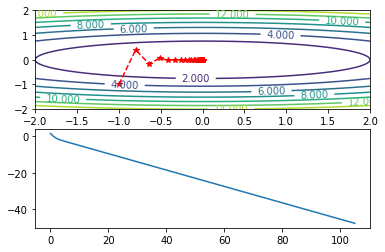

105


In [41]:
xiter,fiter,niter=main_algorithm(f1,step=0.2,xini=np.array([-1,-1]),ls=ls_constant,dc=dc_gradient)
contour_and_f_plot(xiter,fiter, f1,-2,2,-2,2)
print(niter)

3. Testez également la méthode de Newton sur les trois exemples proposés au début du TP et retrouvez les résultats numériques du polycopié en faisant varier le point initial notamment.

C:\Users\nguye\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


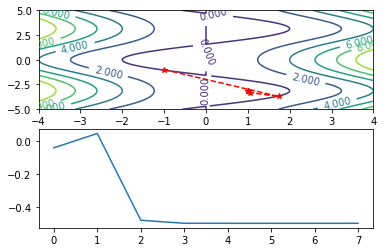

In [35]:
xiter,fiter,niter =main_algorithm(f2,step=1,xini=np.array([-1,-1]),ls=ls_constant,dc=dc_Newton)
contour_and_f_plot(xiter,fiter, f2,-4,4,-5,5)

C:\Users\nguye\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


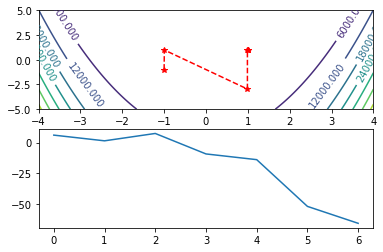

6


In [47]:
xiter,fiter,niter =main_algorithm(f3,step=1,xini=np.array([-1,-1]),ls=ls_constant,dc=dc_Newton)
contour_and_f_plot(xiter,fiter, f3,-4,4,-5,5)
print(niter)

4. Tester la méthode de Newton avec pas de Wolfe sur les fonctions $f_i$, $i=1,2,3$. et comparer les résultats obtenus avec ceux des algos de gradient avec pas de Wolfe et l'algorithme de Newton classique.

C:\Users\nguye\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


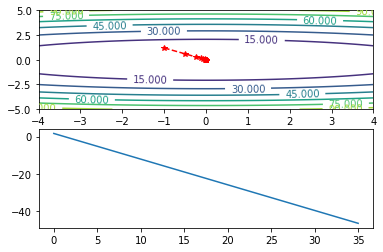

35


In [50]:
xiter1_newton, fiter1_newton, niter1_newton = main_algorithm(f1,step = 0.5,ls=ls_wolfe,dc=dc_Newton)
contour_and_f_plot(xiter1_newton,fiter1_newton,f1,-4,4,-5,5)
print(niter1_newton)

C:\Users\nguye\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


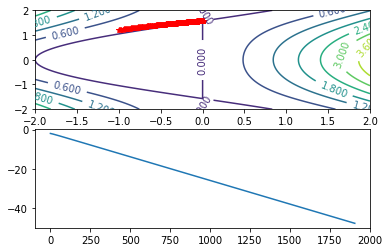

In [39]:
xiter1_newton, fiter2_newton, niter2_newton = main_algorithm(f2,ls=ls_wolfe,dc=dc_Newton)
contour_and_f_plot(xiter2_newton,fiter2_newton,f2)

C:\Users\nguye\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


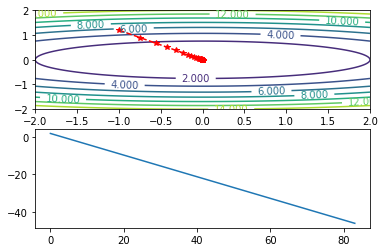

83


In [49]:
xiter1_newton, fiter1_newton, niter1_newton = main_algorithm(f1,step = 0.25,ls=ls_wolfe,dc=dc_Newton)
contour_and_f_plot(xiter1_newton,fiter1_newton,f1)
print(niter1_newton)

In [56]:
xiter, fiter, niter = main_algorithm(f3,step = 0.5,ls=ls_wolfe,dc=dc_gradient)
contour_and_f_plot(xiter,fiter,f1,-4,4,-5,5)
print(niter)

KeyboardInterrupt: 

5. Tester la méthode de Newton avec pas de Wolfe cubique sur les fonctions $f_i$, $i=1,2,3$. et comparer les résultats obtenus avec ceux de l'algorithme de Newton avec pas de Wolfe (non cubique).

6. Comparer le cout des différentes méthodes implémentées.